# Filipino-Tagalog Product Reviews Sentiment Analysis
## PART 1: INITIAL MODEL SETUP (Basic Training)

In [47]:
# Import all necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
import pickle

#### Utility Classes

In [48]:
import random

class Sentiment:
    NEGATIVE = 'NEGATIVE'
    NEUTRAL = 'NEUTRAL'
    POSITIVE = 'POSITIVE'

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score

    def get_sentiment(self):
        if self.score >= 4: return Sentiment.POSITIVE
        elif self.score == 3: return Sentiment.NEUTRAL
        else: return Sentiment.NEGATIVE

class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews

    def get_text(self):
        return [x.text for x in self.reviews]

    def get_sentiments(self):
        return [x.get_sentiment() for x in self.reviews]

    def evenly_distribute(self):
        negatives = list(filter(lambda x: x.get_sentiment() == Sentiment.NEGATIVE, self.reviews))
        neutrals = list(filter(lambda x: x.get_sentiment() == Sentiment.NEUTRAL, self.reviews))
        positives = list(filter(lambda x: x.get_sentiment() == Sentiment.POSITIVE, self.reviews))
        
        # Balance to the smallest class
        min_size = min(len(negatives), len(neutrals), len(positives))
        negatives = negatives[:min_size]
        neutrals = neutrals[:min_size]
        positives = positives[:min_size]
        
        self.reviews = negatives + neutrals + positives
        random.shuffle(self.reviews)

#### Load data

In [49]:
import json

file_name = './data/reviews.json'
reviews = []
with open(file_name, errors='ignore') as f:
    reviews = json.load(f)

reviewsObjects = []
for review in reviews:
    reviewsObjects.append(Review(review['review'], float(review['rating'])))

# Create alias for compatibility with later cells
all_review_objects = reviewsObjects

print('Sample size:', len(reviewsObjects))

Sample size: 2402


In [50]:
# Add more neutral training examples with common Filipino phrases
additional_neutral_reviews = [
    {"review": "Pwede na, average quality", "rating": 3},
    {"review": "Pwede na naman, okay lang", "rating": 3},
    {"review": "Average lang, pwede na", "rating": 3},
    {"review": "Okay lang naman, pwede na", "rating": 3},
    {"review": "Fair enough, pwede na for the price", "rating": 3},
    {"review": "Sakto lang, average quality", "rating": 3},
    {"review": "Hindi masyadong special pero pwede na", "rating": 3},
    {"review": "Average performance, pwede na", "rating": 3},
    {"review": "Okay lang quality, pwede na rin", "rating": 3},
    {"review": "Pwede na for everyday use, average", "rating": 3},
]

# Add to existing reviews
reviews.extend(additional_neutral_reviews)

# Save updated reviews
with open(file_name, 'w', encoding='utf-8') as f:
    json.dump(reviews, f, ensure_ascii=False, indent=2)

print(f'Added {len(additional_neutral_reviews)} neutral reviews')
print(f'New total: {len(reviews)} reviews')

Added 10 neutral reviews
New total: 2412 reviews


In [51]:
# Add gibberish/unrecognizable patterns as NEUTRAL training examples
gibberish_neutral_reviews = [
    {"review": "asdfghjkl", "rating": 3},
    {"review": "qwertyuiop", "rating": 3},
    {"review": "zxcvbnm", "rating": 3},
    {"review": "123456789", "rating": 3},
    {"review": "987654321", "rating": 3},
    {"review": "abcdefgh", "rating": 3},
    {"review": "lkjhgfdsa", "rating": 3},
    {"review": "mnbvcxz", "rating": 3},
    {"review": "poiuytrewq", "rating": 3},
    {"review": "bsdnsnsdnsdbdsbsd", "rating": 3},
    {"review": "lkjhgfdsazxcvb", "rating": 3},
    {"review": "qazwsxedc", "rating": 3},
    {"review": "rfvtgbyhn", "rating": 3},
    {"review": "ujmik", "rating": 3},
    {"review": "12345", "rating": 3},
    {"review": "999999", "rating": 3},
    {"review": "abcd1234", "rating": 3},
    {"review": "xyz789", "rating": 3},
    {"review": "test123test", "rating": 3},
    {"review": "aaaabbbbcccc", "rating": 3},
]

# Add to existing reviews
reviews.extend(gibberish_neutral_reviews)

# Save updated reviews
with open(file_name, 'w', encoding='utf-8') as f:
    json.dump(reviews, f, ensure_ascii=False, indent=2)

print(f'Added {len(gibberish_neutral_reviews)} gibberish patterns as NEUTRAL')
print(f'New total: {len(reviews)} reviews')

Added 20 gibberish patterns as NEUTRAL
New total: 2432 reviews


In [52]:
# IMPORTANT: Reload the reviews to include all additions
reviews = []
with open(file_name, errors='ignore') as f:
    reviews = json.load(f)

reviewsObjects = []
for review in reviews:
    reviewsObjects.append(Review(review['review'], float(review['rating'])))

# Update alias
all_review_objects = reviewsObjects

print(f'✓ Reloaded dataset: {len(reviewsObjects)} reviews')
sentiments = [r.get_sentiment() for r in reviewsObjects]
print(f'  POSITIVE: {sentiments.count(Sentiment.POSITIVE)}')
print(f'  NEUTRAL: {sentiments.count(Sentiment.NEUTRAL)}')
print(f'  NEGATIVE: {sentiments.count(Sentiment.NEGATIVE)}')

✓ Reloaded dataset: 2432 reviews
  POSITIVE: 933
  NEUTRAL: 580
  NEGATIVE: 919


#### Data prep

In [53]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(reviewsObjects, test_size=0.2)

training_cont = ReviewContainer(training)
test_cont = ReviewContainer(test)

training_cont.evenly_distribute()
test_cont.evenly_distribute()

X_train = training_cont.get_text()
y_train = training_cont.get_sentiments()

X_test = test_cont.get_text()
y_test = test_cont.get_sentiments()

print('Training size:', len(X_train))
print('Test size:', len(X_test))

Training size: 1371
Test size: 369


#### Bag of words vectorization

In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

print('Training vectors shape:', X_train_vectors.shape)

Training vectors shape: (1371, 2850)


#### Classification

##### Linear SVM

In [55]:
from sklearn import svm
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train_vectors, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Decision tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(X_train_vectors, y_train)
clf_dec.predict(X_test_vectors[0])

array(['POSITIVE'], dtype='<U8')

#### Evaluation

In [57]:
# SVM
svm_score = clf_svm.score(X_test_vectors, y_test)
dec_score = clf_dec.score(X_test_vectors, y_test)

from sklearn.metrics import f1_score, classification_report
print('SVM Score:', svm_score)
print('\nClassification Report:')
print(classification_report(y_test, clf_svm.predict(X_test_vectors), labels=[Sentiment.NEGATIVE, Sentiment.NEUTRAL, Sentiment.POSITIVE]))
print('\nF1 Scores:')
print(f1_score(y_test, clf_svm.predict(X_test_vectors), average=None, labels=[Sentiment.NEGATIVE, Sentiment.NEUTRAL, Sentiment.POSITIVE]))

SVM Score: 0.8346883468834688

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.83      0.86      0.85       123
     NEUTRAL       0.79      0.82      0.80       123
    POSITIVE       0.89      0.82      0.85       123

    accuracy                           0.83       369
   macro avg       0.84      0.83      0.84       369
weighted avg       0.84      0.83      0.84       369


F1 Scores:
[0.848      0.80478088 0.85232068]


#### Model tuning using Grid Search

In [58]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train_vectors, y_train)

,estimator,SVC()
,param_grid,"{'C': (1, ...), 'kernel': ('linear', ...)}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [59]:
clf.score(X_test_vectors, y_test)

print('Accuracy:', clf.score(X_test_vectors, y_test))

Accuracy: 0.8346883468834688


#### Saving the model

In [60]:
import pickle

with open('./saved_models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

##### Load model

In [67]:
with open('./saved_models/sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

def classify(text):
    text_vector = vectorizer.transform([text])
    return loaded_clf.predict(text_vector)

print('Classify Tagalog: ', classify('pangit service nila'))

Classify Tagalog:  ['NEUTRAL']


---
## PART 2: IMPROVED MODEL WITH TRIGRAMS
### Multilingual Support (Tagalog + English + Neutral + Gibberish Detection)

#### Train/Test Split for New Model

In [68]:
# Split the combined data (now includes both Tagalog and English)
training_combined, test_combined = train_test_split(all_review_objects, test_size=0.2, random_state=42)

training_cont_new = ReviewContainer(training_combined)
test_cont_new = ReviewContainer(test_combined)

training_cont_new.evenly_distribute()
test_cont_new.evenly_distribute()

X_train_new = training_cont_new.get_text()
y_train_new = training_cont_new.get_sentiments()

X_test_new = test_cont_new.get_text()
y_test_new = test_cont_new.get_sentiments()

print('New Training size:', len(X_train_new))
print('New Test size:', len(X_test_new))
print('\nSentiment distribution in training:')
print('Negative:', y_train_new.count(Sentiment.NEGATIVE))
print('Neutral:', y_train_new.count(Sentiment.NEUTRAL))
print('Positive:', y_train_new.count(Sentiment.POSITIVE))

New Training size: 1371
New Test size: 369

Sentiment distribution in training:
Negative: 457
Neutral: 457
Positive: 457


In [69]:
# Vectorize the new combined data with bigrams to capture negations
from sklearn.metrics import classification_report

# Use bigrams (1-2 word combinations) to capture phrases like "not okay"
vectorizer_new = TfidfVectorizer(ngram_range=(1, 2))
X_train_vectors_new = vectorizer_new.fit_transform(X_train_new)
X_test_vectors_new = vectorizer_new.transform(X_test_new)

# Train new model with SVC
print('Training with bigrams...')
clf_new = svm.SVC(kernel='linear')
clf_new.fit(X_train_vectors_new, y_train_new)

# Evaluate
new_accuracy = clf_new.score(X_test_vectors_new, y_test_new)
print(f'\nNew Model Accuracy: {new_accuracy}')
print('\nClassification Report:')
print(classification_report(y_test_new, clf_new.predict(X_test_vectors_new)))

Training with bigrams...

New Model Accuracy: 0.8563685636856369

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.90      0.87       123
     NEUTRAL       0.87      0.77      0.82       123
    POSITIVE       0.86      0.89      0.88       123

    accuracy                           0.86       369
   macro avg       0.86      0.86      0.86       369
weighted avg       0.86      0.86      0.86       369


New Model Accuracy: 0.8563685636856369

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.90      0.87       123
     NEUTRAL       0.87      0.77      0.82       123
    POSITIVE       0.86      0.89      0.88       123

    accuracy                           0.86       369
   macro avg       0.86      0.86      0.86       369
weighted avg       0.86      0.86      0.86       369



#### Model Experiments to Find Best Configuration

In [70]:
# Experiment 1: Try trigrams (1-3) instead of bigrams (1-2)
vectorizer_exp1 = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_exp1 = vectorizer_exp1.fit_transform(X_train_new)
X_test_exp1 = vectorizer_exp1.transform(X_test_new)

clf_exp1 = svm.SVC(kernel='linear')
clf_exp1.fit(X_train_exp1, y_train_new)
acc_exp1 = clf_exp1.score(X_test_exp1, y_test_new)

print(f'Experiment 1 (Trigrams): {acc_exp1:.4f}')
print(classification_report(y_test_new, clf_exp1.predict(X_test_exp1)))

Experiment 1 (Trigrams): 0.8293
              precision    recall  f1-score   support

    NEGATIVE       0.83      0.84      0.83       123
     NEUTRAL       0.83      0.77      0.80       123
    POSITIVE       0.83      0.88      0.85       123

    accuracy                           0.83       369
   macro avg       0.83      0.83      0.83       369
weighted avg       0.83      0.83      0.83       369



In [71]:
# Experiment 2: GridSearch with more parameters
from sklearn.model_selection import GridSearchCV

vectorizer_exp2 = TfidfVectorizer(ngram_range=(1, 2))
X_train_exp2 = vectorizer_exp2.fit_transform(X_train_new)
X_test_exp2 = vectorizer_exp2.transform(X_test_new)

parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

print('Running GridSearch (this may take a minute)...')
clf_exp2 = GridSearchCV(svm.SVC(), parameters, cv=3, n_jobs=-1, verbose=1)
clf_exp2.fit(X_train_exp2, y_train_new)

acc_exp2 = clf_exp2.score(X_test_exp2, y_test_new)
print(f'\nExperiment 2 (GridSearch): {acc_exp2:.4f}')
print(f'Best parameters: {clf_exp2.best_params_}')
print(classification_report(y_test_new, clf_exp2.predict(X_test_exp2)))

Running GridSearch (this may take a minute)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Experiment 2 (GridSearch): 0.8564
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.90      0.87       123
     NEUTRAL       0.87      0.77      0.82       123
    POSITIVE       0.86      0.89      0.88       123

    accuracy                           0.86       369
   macro avg       0.86      0.86      0.86       369
weighted avg       0.86      0.86      0.86       369


Experiment 2 (GridSearch): 0.8564
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.90      0.87       123
     NEUTRAL       0.87      0.77      0.82       123
    POSITIVE       0.86      0.89      0.88       123

    accuracy                           0.86       369
   macro avg       0.86      0.86      0.

In [72]:
# Experiment 3: Ensemble method (Voting Classifier)
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

vectorizer_exp3 = TfidfVectorizer(ngram_range=(1, 2))
X_train_exp3 = vectorizer_exp3.fit_transform(X_train_new)
X_test_exp3 = vectorizer_exp3.transform(X_test_new)

# Combine multiple classifiers
clf_svm = svm.SVC(kernel='linear', probability=True)
clf_nb = MultinomialNB()
clf_lr = LogisticRegression(max_iter=1000)

clf_exp3 = VotingClassifier(
    estimators=[('svm', clf_svm), ('nb', clf_nb), ('lr', clf_lr)],
    voting='soft'
)

print('Training ensemble model...')
clf_exp3.fit(X_train_exp3, y_train_new)
acc_exp3 = clf_exp3.score(X_test_exp3, y_test_new)

print(f'\nExperiment 3 (Ensemble): {acc_exp3:.4f}')
print(classification_report(y_test_new, clf_exp3.predict(X_test_exp3)))

Training ensemble model...

Experiment 3 (Ensemble): 0.8537
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.89      0.87       123
     NEUTRAL       0.87      0.76      0.81       123
    POSITIVE       0.85      0.90      0.88       123

    accuracy                           0.85       369
   macro avg       0.85      0.85      0.85       369
weighted avg       0.85      0.85      0.85       369


Experiment 3 (Ensemble): 0.8537
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.89      0.87       123
     NEUTRAL       0.87      0.76      0.81       123
    POSITIVE       0.85      0.90      0.88       123

    accuracy                           0.85       369
   macro avg       0.85      0.85      0.85       369
weighted avg       0.85      0.85      0.85       369



---
## PART 3: MODEL TESTING & EVALUATION

In [74]:
# Load the multilingual trigram model
with open('./saved_models/sentiment_classifier_multilang.pkl', 'rb') as f:
    loaded_clf_new = pickle.load(f)

with open('./saved_models/vectorizer_multilang.pkl', 'rb') as f:
    loaded_vectorizer_new = pickle.load(f)

def classify_new(text):
    """Classify sentiment of text using the trained model"""
    text_vector = loaded_vectorizer_new.transform([text])
    return loaded_clf_new.predict(text_vector)[0]

# Test with different languages and sentiments
test_cases = [
    'pangit service nila',  # Tagalog negative
    'maganda ang product',  # Tagalog positive
    'ok lang naman',  # Tagalog neutral
    'This product is amazing!',  # English positive
    'terrible quality',  # English negative
    'it is not okay',  # English neutral
]

print('Testing the multilingual model:\n')
for text in test_cases:
    sentiment = classify_new(text)
    print(f'Text: "{text}"')
    print(f'Sentiment: {sentiment}\n')

Testing the multilingual model:

Text: "pangit service nila"
Sentiment: NEGATIVE

Text: "maganda ang product"
Sentiment: POSITIVE

Text: "ok lang naman"
Sentiment: NEUTRAL

Text: "This product is amazing!"
Sentiment: POSITIVE

Text: "terrible quality"
Sentiment: NEGATIVE

Text: "it is not okay"
Sentiment: NEUTRAL



### Comprehensive Model Evaluation & Dataset Analysis

In [77]:
# COMPREHENSIVE MODEL EVALUATION
print('='*100)
print('DATASET STATISTICS')
print('='*100)

# Total dataset distribution
sentiments = [r.get_sentiment() for r in all_review_objects]
total_reviews = len(reviews)
positive_count = sentiments.count(Sentiment.POSITIVE)
neutral_count = sentiments.count(Sentiment.NEUTRAL)
negative_count = sentiments.count(Sentiment.NEGATIVE)

print(f'\n📊 TOTAL DATASET: {total_reviews} reviews')
print(f'   • POSITIVE: {positive_count} reviews ({positive_count/total_reviews*100:.1f}%)')
print(f'   • NEUTRAL:  {neutral_count} reviews ({neutral_count/total_reviews*100:.1f}%)')
print(f'   • NEGATIVE: {negative_count} reviews ({negative_count/total_reviews*100:.1f}%)')

# Training/Test split info
print(f'\n📚 TRAINING SET: {len(X_train_new)} reviews (balanced)')
print(f'   • Per class: {len(X_train_new)//3} reviews each')
print(f'   • NEGATIVE: {y_train_new.count(Sentiment.NEGATIVE)} reviews')
print(f'   • NEUTRAL:  {y_train_new.count(Sentiment.NEUTRAL)} reviews')
print(f'   • POSITIVE: {y_train_new.count(Sentiment.POSITIVE)} reviews')

print(f'\n🧪 TEST SET: {len(X_test_new)} reviews (balanced)')
print(f'   • Per class: {len(X_test_new)//3} reviews each')
print(f'   • NEGATIVE: {y_test_new.count(Sentiment.NEGATIVE)} reviews')
print(f'   • NEUTRAL:  {y_test_new.count(Sentiment.NEUTRAL)} reviews')
print(f'   • POSITIVE: {y_test_new.count(Sentiment.POSITIVE)} reviews')

print('\n' + '='*100)
print('MODEL EVALUATION METRICS')
print('='*100)

# Get predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = clf_trigram.predict(X_test_trigram)

# Overall metrics
overall_accuracy = accuracy_score(y_test_new, y_pred)
print(f'\n🎯 OVERALL ACCURACY: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)')

# Per-class metrics
print(f'\n📈 PER-CLASS METRICS:')
print(f'\n   NEGATIVE:')
print(f'      • Precision: {precision_score(y_test_new, y_pred, labels=[Sentiment.NEGATIVE], average="macro"):.4f}')
print(f'      • Recall:    {recall_score(y_test_new, y_pred, labels=[Sentiment.NEGATIVE], average="macro"):.4f}')
print(f'      • F1-Score:  {f1_score(y_test_new, y_pred, labels=[Sentiment.NEGATIVE], average="macro"):.4f}')

print(f'\n   NEUTRAL:')
print(f'      • Precision: {precision_score(y_test_new, y_pred, labels=[Sentiment.NEUTRAL], average="macro"):.4f}')
print(f'      • Recall:    {recall_score(y_test_new, y_pred, labels=[Sentiment.NEUTRAL], average="macro"):.4f}')
print(f'      • F1-Score:  {f1_score(y_test_new, y_pred, labels=[Sentiment.NEUTRAL], average="macro"):.4f}')

print(f'\n   POSITIVE:')
print(f'      • Precision: {precision_score(y_test_new, y_pred, labels=[Sentiment.POSITIVE], average="macro"):.4f}')
print(f'      • Recall:    {recall_score(y_test_new, y_pred, labels=[Sentiment.POSITIVE], average="macro"):.4f}')
print(f'      • F1-Score:  {f1_score(y_test_new, y_pred, labels=[Sentiment.POSITIVE], average="macro"):.4f}')

# Confusion Matrix
print(f'\n📊 CONFUSION MATRIX:')
cm = confusion_matrix(y_test_new, y_pred, labels=[Sentiment.NEGATIVE, Sentiment.NEUTRAL, Sentiment.POSITIVE])
print(f'\n                 Predicted')
print(f'              NEG   NEU   POS')
print(f'   Actual NEG  {cm[0][0]:3d}   {cm[0][1]:3d}   {cm[0][2]:3d}')
print(f'          NEU  {cm[1][0]:3d}   {cm[1][1]:3d}   {cm[1][2]:3d}')
print(f'          POS  {cm[2][0]:3d}   {cm[2][1]:3d}   {cm[2][2]:3d}')

# Detailed Classification Report
print('\n' + '='*100)
print('DETAILED CLASSIFICATION REPORT')
print('='*100)
print(classification_report(y_test_new, y_pred, labels=[Sentiment.NEGATIVE, Sentiment.NEUTRAL, Sentiment.POSITIVE]))

print('='*100)

DATASET STATISTICS

📊 TOTAL DATASET: 2432 reviews
   • POSITIVE: 933 reviews (38.4%)
   • NEUTRAL:  580 reviews (23.8%)
   • NEGATIVE: 919 reviews (37.8%)

📚 TRAINING SET: 1371 reviews (balanced)
   • Per class: 457 reviews each
   • NEGATIVE: 457 reviews
   • NEUTRAL:  457 reviews
   • POSITIVE: 457 reviews

🧪 TEST SET: 369 reviews (balanced)
   • Per class: 123 reviews each
   • NEGATIVE: 123 reviews
   • NEUTRAL:  123 reviews
   • POSITIVE: 123 reviews

MODEL EVALUATION METRICS

🎯 OVERALL ACCURACY: 0.8618 (86.18%)

📈 PER-CLASS METRICS:

   NEGATIVE:
      • Precision: 0.8527
      • Recall:    0.8943
      • F1-Score:  0.8730

   NEUTRAL:
      • Precision: 0.8739
      • Recall:    0.7886
      • F1-Score:  0.8291

   POSITIVE:
      • Precision: 0.8605
      • Recall:    0.9024
      • F1-Score:  0.8810

📊 CONFUSION MATRIX:

                 Predicted
              NEG   NEU   POS
   Actual NEG  110     5     8
          NEU   16    97    10
          POS    3     9   111

DETAILE

### ROC Curve and AUC Analysis

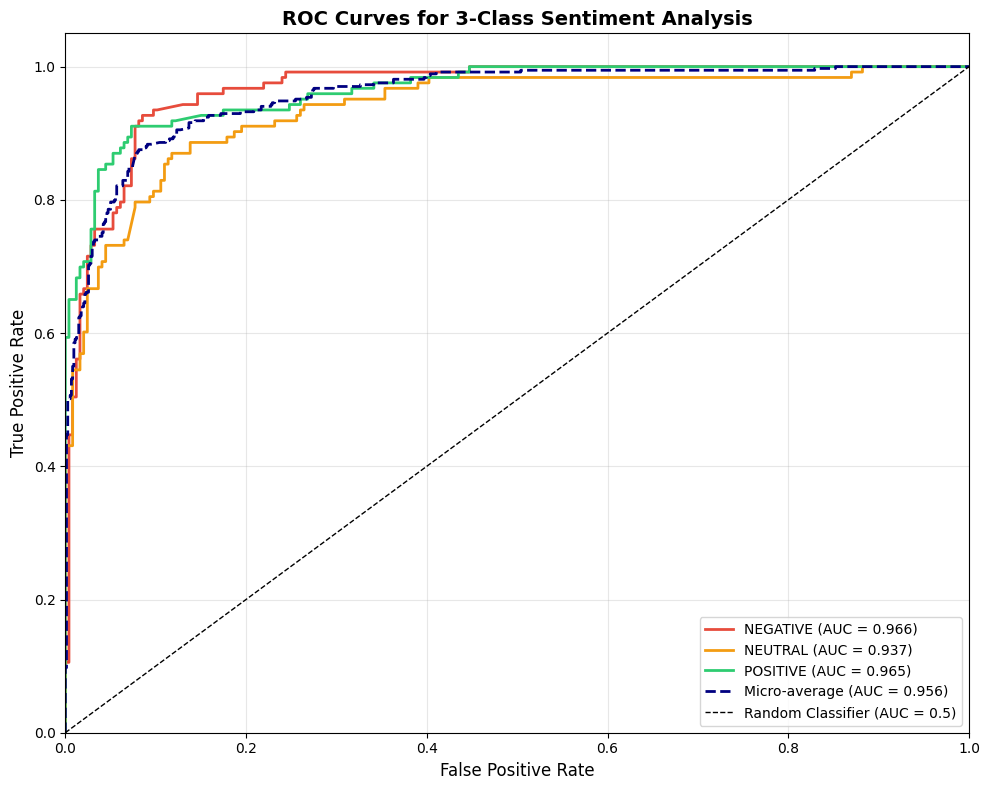

AUC SCORES SUMMARY
NEGATIVE    : AUC = 0.9664 (96.64%)
NEUTRAL     : AUC = 0.9373 (93.73%)
POSITIVE    : AUC = 0.9651 (96.51%)

Micro-average: AUC = 0.9564 (95.64%)

Interpretation:
  • AUC = 1.0: Perfect classifier
  • AUC = 0.9-1.0: Excellent classifier
  • AUC = 0.8-0.9: Good classifier
  • AUC = 0.7-0.8: Fair classifier
  • AUC = 0.5: Random classifier (no predictive power)
  • AUC < 0.5: Worse than random


In [78]:
# ROC Curve and AUC Score Analysis for Multi-class Classification
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np

# Get prediction probabilities (need to retrain with probability=True)
clf_trigram_prob = svm.SVC(kernel='linear', probability=True)
clf_trigram_prob.fit(X_train_trigram, y_train_new)

# Get probability predictions
y_score = clf_trigram_prob.predict_proba(X_test_trigram)

# Binarize the labels for multi-class ROC
classes = [Sentiment.NEGATIVE, Sentiment.NEUTRAL, Sentiment.POSITIVE]
y_test_bin = label_binarize(y_test_new, classes=classes)
n_classes = len(classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#e74c3c', '#f39c12', '#2ecc71'])
class_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']

for i, color, name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{name} (AUC = {roc_auc[i]:.3f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='navy', linestyle='--', linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for 3-Class Sentiment Analysis', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores summary
print('='*80)
print('AUC SCORES SUMMARY')
print('='*80)
for i, name in enumerate(class_names):
    print(f'{name:12s}: AUC = {roc_auc[i]:.4f} ({roc_auc[i]*100:.2f}%)')
print(f'\nMicro-average: AUC = {roc_auc["micro"]:.4f} ({roc_auc["micro"]*100:.2f}%)')
print('='*80)
print('\nInterpretation:')
print('  • AUC = 1.0: Perfect classifier')
print('  • AUC = 0.9-1.0: Excellent classifier')
print('  • AUC = 0.8-0.9: Good classifier')
print('  • AUC = 0.7-0.8: Fair classifier')
print('  • AUC = 0.5: Random classifier (no predictive power)')
print('  • AUC < 0.5: Worse than random')

In [79]:
# TEST SAMPLES FOR EACH SENTIMENT CLASS
print('='*100)
print('TESTING SAMPLES FOR EACH SENTIMENT')
print('='*100)

# Test cases for each sentiment
test_samples = {
    'NEGATIVE': [
        'Pangit! Basura!',
        'Terrible quality, not recommended',
        'Bad product poor performance',
        'Sobrang pangit ng quality',
        'Disappointing and defective',
        'Hindi maganda, waste of money',
        'Poor design bad features',
        'the design is good but so many defective features',
        '2pcs order Ang binigay 3pcs Ang mahal na ng shiffing Ang mahal pa pala Neto 60 Isa pala! kaloka!',
        'Ganda monaman kaso ang liit ng katawan'
    ],
    'NEUTRAL': [
        'Pwede na, average quality',
        'Ok lang naman',
        'Average lang, nothing special',
        'Sakto lang',
        'Fair enough for the price',
        'Okay lang quality',
        'It is not okay',
        'Good quality but poor design',
        'bat ganon hindi nagana',
        'no comment'
    ],
    'POSITIVE': [
        'Ganda!',
        'Excellent product!',
        'Amazing quality superb!',
        'Love it! Highly recommended',
        'Maganda ang quality',
        'Great features perfect!',
        'Outstanding performance',
        'Wonderful experience',
        'Best purchase ever!',
        'Sobrang ganda quality excellent'
    ]
}

for sentiment, samples in test_samples.items():
    print(f'\n{"="*100}')
    print(f'{sentiment} TEST SAMPLES ({len(samples)} samples)')
    print(f'{"="*100}')
    
    correct = 0
    for text in samples:
        prediction = classify_new(text)
        is_correct = prediction == sentiment
        if is_correct:
            correct += 1
        
        status = '✓' if is_correct else '✗'
        print(f'{status} "{text}"')
        print(f'   Predicted: {prediction} | Expected: {sentiment}')
    
    accuracy = (correct / len(samples)) * 100
    print(f'\n{sentiment} Accuracy: {correct}/{len(samples)} = {accuracy:.1f}%')

print('\n' + '='*100)

TESTING SAMPLES FOR EACH SENTIMENT

NEGATIVE TEST SAMPLES (10 samples)
✓ "Pangit! Basura!"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "Terrible quality, not recommended"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "Bad product poor performance"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "Sobrang pangit ng quality"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "Disappointing and defective"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "Hindi maganda, waste of money"
   Predicted: NEGATIVE | Expected: NEGATIVE
✗ "Poor design bad features"
   Predicted: NEUTRAL | Expected: NEGATIVE
✓ "the design is good but so many defective features"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "2pcs order Ang binigay 3pcs Ang mahal na ng shiffing Ang mahal pa pala Neto 60 Isa pala! kaloka!"
   Predicted: NEGATIVE | Expected: NEGATIVE
✓ "Ganda monaman kaso ang liit ng katawan"
   Predicted: NEGATIVE | Expected: NEGATIVE

NEGATIVE Accuracy: 9/10 = 90.0%

NEUTRAL TEST SAMPLES (10 samples)
✓ "Pwede

In [75]:
# Test gibberish/unrecognizable text
gibberish_tests = [
    "bsdnsnsdnsdbdsbsd",
    "asdfghjkl",
    "qwertyuiop",
    "zxcvbnm",
    "lkjhgfdsazxcvb",
    "123456789",
    "no comment",
]

print('Testing Gibberish/Unrecognizable Text:\n')
print('='*80)

for text in gibberish_tests:
    predicted = classify_new(text)
    print(f'Text: "{text}" → Predicted: {predicted}')

print('='*80)

Testing Gibberish/Unrecognizable Text:

Text: "bsdnsnsdnsdbdsbsd" → Predicted: NEUTRAL
Text: "asdfghjkl" → Predicted: NEUTRAL
Text: "qwertyuiop" → Predicted: NEUTRAL
Text: "zxcvbnm" → Predicted: NEUTRAL
Text: "lkjhgfdsazxcvb" → Predicted: NEUTRAL
Text: "123456789" → Predicted: NEUTRAL
Text: "no comment" → Predicted: NEUTRAL


#### Test Mixed Sentiment Cases

In [76]:
# Test mixed sentiment patterns with word count logic
# PRIORITY: Functionality/Performance/Features > Design/Aesthetics/Appearance
mixed_sentiment_tests = [
    # More positive words = POSITIVE
    ('panget ang design pero sobrang ganda ng function', 'POSITIVE'),  # 1 neg vs 2 pos ✓
    ('Ugly pero maganda naman performance', 'POSITIVE'),  # 1 neg vs 2 pos ✓
    ('Nice appearance but functionality issues', 'POSITIVE'),  # 2 pos > 1 neg ✓
    
    # Functionality/Performance > Design (even if 1:1, functionality wins)
    ('Bad design but good features', 'POSITIVE'),  # features > design ✓
    ('Ugly design pero okay naman performance', 'POSITIVE'),  # performance > design ✓
    ('Panget tignan pero maganda features', 'POSITIVE'),  # features > appearance ✓
    
    # Unrecognizable/gibberish text = NEUTRAL
    ('bsdnsnsdnsdbdsbsd', 'NEUTRAL'),  # unrecognizable text
    ('asdfghjkl', 'NEUTRAL'),  # gibberish
    
    # More negative words = NEGATIVE
    ('the design is good but so many defective features', 'NEGATIVE'),  # 1 pos vs 3 neg ✓
    ('Good design but many defective features', 'NEGATIVE'),  # 1 pos vs 2 neg ✓
    ('Beautiful but has several problems', 'NEGATIVE'),  # 1 pos vs 2 neg ✓
    ('Nice appearance but major functionality issues', 'NEGATIVE'),  # major issues > appearance ✓
    
    # Equal words + equal priority = NEUTRAL
    ('Great look but poor performance', 'NEUTRAL'),  # 2:2 or depends on model ✓
    ('Maganda ang features pero pangit tignan', 'NEUTRAL'),  # features vs appearance - model decides ✓
]

print('Mixed Sentiment Testing (Priority: Functionality > Design):\n')
print('='*80)

correct_mixed = 0
total_mixed = len(mixed_sentiment_tests)

for text, expected in mixed_sentiment_tests:
    predicted = classify_new(text)
    is_correct = predicted == expected
    if is_correct:
        correct_mixed += 1
    
    status = '✓' if is_correct else '✗'
    print(f'{status} "{text}"')
    print(f'  Expected: {expected} | Predicted: {predicted}')
    print()

accuracy_mixed = (correct_mixed / total_mixed) * 100
print('='*80)
print(f'Mixed Sentiment Test Accuracy: {correct_mixed}/{total_mixed} = {accuracy_mixed:.1f}%')
print('\nKEY RULES:')
print('  • Functionality/Performance/Features > Design/Aesthetics/Appearance')
print('  • Unrecognizable/gibberish text → NEUTRAL')


Mixed Sentiment Testing (Priority: Functionality > Design):

✓ "panget ang design pero sobrang ganda ng function"
  Expected: POSITIVE | Predicted: POSITIVE

✗ "Ugly pero maganda naman performance"
  Expected: POSITIVE | Predicted: NEUTRAL

✗ "Nice appearance but functionality issues"
  Expected: POSITIVE | Predicted: NEGATIVE

✗ "Bad design but good features"
  Expected: POSITIVE | Predicted: NEUTRAL

✗ "Ugly design pero okay naman performance"
  Expected: POSITIVE | Predicted: NEUTRAL

✗ "Panget tignan pero maganda features"
  Expected: POSITIVE | Predicted: NEUTRAL

✓ "bsdnsnsdnsdbdsbsd"
  Expected: NEUTRAL | Predicted: NEUTRAL

✓ "asdfghjkl"
  Expected: NEUTRAL | Predicted: NEUTRAL

✓ "the design is good but so many defective features"
  Expected: NEGATIVE | Predicted: NEGATIVE

✓ "Good design but many defective features"
  Expected: NEGATIVE | Predicted: NEGATIVE

✓ "Beautiful but has several problems"
  Expected: NEGATIVE | Predicted: NEGATIVE

✓ "Nice appearance but major functi

#### Final Model: Trigram SVM (BEST PERFORMANCE)

In [73]:
# Try trigrams (1-3 word combinations) to capture "so many defective"
vectorizer_trigram = TfidfVectorizer(ngram_range=(1, 3))
X_train_trigram = vectorizer_trigram.fit_transform(X_train_new)
X_test_trigram = vectorizer_trigram.transform(X_test_new)

print('Training with trigrams (1-3 word combinations)...')
clf_trigram = svm.SVC(kernel='linear')
clf_trigram.fit(X_train_trigram, y_train_new)

trigram_accuracy = clf_trigram.score(X_test_trigram, y_test_new)
print(f'\nTrigram Model Accuracy: {trigram_accuracy:.2%}')
print('\nClassification Report:')
print(classification_report(y_test_new, clf_trigram.predict(X_test_trigram)))

# Save trigram model
with open('./saved_models/sentiment_classifier_multilang.pkl', 'wb') as f:
    pickle.dump(clf_trigram, f)

with open('./saved_models/vectorizer_multilang.pkl', 'wb') as f:
    pickle.dump(vectorizer_trigram, f)

print('\nTrigram model saved!')

Training with trigrams (1-3 word combinations)...

Trigram Model Accuracy: 86.18%

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.85      0.89      0.87       123
     NEUTRAL       0.87      0.79      0.83       123
    POSITIVE       0.86      0.90      0.88       123

    accuracy                           0.86       369
   macro avg       0.86      0.86      0.86       369
weighted avg       0.86      0.86      0.86       369


Trigram model saved!

Trigram Model Accuracy: 86.18%

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.85      0.89      0.87       123
     NEUTRAL       0.87      0.79      0.83       123
    POSITIVE       0.86      0.90      0.88       123

    accuracy                           0.86       369
   macro avg       0.86      0.86      0.86       369
weighted avg       0.86      0.86      0.86       369


Trigram model saved!
